# **8. Learning to Rank & Bayesian Personalized Ranking**

---
## Outline:

1. Background
2. Simplified Workflows.
3. Importing Data
4. Data Preparations
5. Data Preprocessing
6. Modeling
7. Hyperparameter Tuning
8. Evaluation
9. Decision Process (Recommendation Process)

# **Background**
---

## Problem Description
---

- Spotify, a Steaming Music Company has a problem with their customer.
- Three months ago our ML / Data Scientist team has developed recommender system model, our current best approach is using **Alternating Least Squares**
- Our metrics still perceived as Number of Relevant items for User divided by Recommended items

The problem are :     
- User has limited budget of time to listen songs in Spotify


So we want user to receive ranked result, due to that constraint

Previously, in last model we treat each item the same way, by predicting relevance score of each item, However the model itself is not directly optimized for ranking

We already solved the user churn previously, however we see another problem appear that user session droppped to 15%. If we cannot solved this, then user who reduced activity on spority could decide to stop subscription, which will lead to the churn problem again

## Business Objective
---

Our business objective would be increasing user session up to **15%**

## Solution
---


- We can fix previous recommendation algorithm, instead of using model that are not directly optimized for ranking, we are going to use model that are trained to optimized the ranking metrics

**Our task** is shifted, from :     
**Predicting preference of each item** score to **Predicting Ranking each item ranking** for users

We now have a clearer picture what we should do, However we need more precise solution in recommender system context.

What is the solution ?

We can use Learning to Rank model for Recommender System

## Model Metrics
---
We have already established some points :
- Our task is to predict the item ranking for each users
- We will use Learning to Rank concept



Some possible Metrics :     
1. Normalized Discounted Cumulative Gain (NDCG)
2. Mean Average Precision
3. Reciprocal Rank

For now, we choose **Normalized Discounted Cumulative Gain @5**

## Data Description
---

- The data is obtained from [Heatrec Dataset](https://grouplens.org/datasets/hetrec-2011/)


Only one file we use

**song count data** : `user_artist_play.csv`


|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`userID`|The user ID|`object`|
|`artistID`|artist that user listen to |`int`|
|`weight`|Number of Plays |`int`|


**artist name** : `artist_name.csv`



|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`id`|artist ID|`object`|
|`name`|artist name|`int`|



# **Recommender System Workflow** (Simplified)
---

## 1. Importing Data

1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## 2.Modelling : Implicit Feedback Recommender

1. Creating Utility Matrix
2. Training + Model Selection  :     
    - Baseline : Alternating least Squares
    - Bayesian Personalized Ranking

4. Evaluating Model
    - NDCG @ 5

## 3. Generating Recommendation / Predictions

1. Giving recommendation for user

# **1. Importing Data**
---

What do we do?
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## Load the data

In [1]:
# Load this library
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

Load the data from given data path

In [2]:
song_play_path = '../data/user_artist_play.csv'

In [3]:
song_play_data = pd.read_csv(song_play_path,
                          delimiter = ',')

In [4]:
song_play_data.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Check data shapes & types

In [5]:
# Check data shapes
song_play_data.shape

(92834, 3)

In [6]:
song_play_data.userID.nunique()

1892

In [7]:
song_play_data.userID.nunique()

1892

In [8]:
# Check data types
song_play_data.dtypes

userID      int64
artistID    int64
weight      int64
dtype: object

We see that our features have correct data types

## Handling duplicates data


We need to check that there is no user ID that rates similar movie ID more than one.

In [9]:
# Check duplicate data
song_play_data.duplicated(subset=['userID', 'artistID']).sum()

0

Great, Our Data is Free From Duplicated Data

## Create load function

Finally, we can create load data function

In [10]:
def load_song_data(path):
    """
    Function to load data & remove from duplicates

    Parameters
    ----------
    path : str
        The path of song play  data

    Returns
    -------
    song_play_data : pandas DataFrame
        The sample of song play data
    """
    # Load data
    song_play_data = pd.read_csv(path, delimiter=',')
    print('Original data shape :', song_play_data.shape)


    return song_play_data


In [11]:
# Load rating data
song_play_data = load_song_data(path = song_play_path)

Original data shape : (92834, 3)


In [12]:
song_play_data.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


# **2. Modelling**: Learning to Rank
---

## Background
---

Previously, we have learn some models :    
- Explicit Feedback Recommender System
- Implicit Feedback Recommender System

Both approach focus on **generating** accurate prediction as possible, however the model is not directly optimize for ranking task

We can implement learning to rank approach..

<center>
<img src="../assets/ltr_alt.jpg" />
</center>

## Workflow
---

To create a personalized RecSys, we can follow these steps:

1. Data Preparation --> Create utility matrix & Split Train-Test
2. Train recommendation model --> Baseline (Alternating Least Squares) &  Bayesian Personalized Ranking
3. Choosing Best Model
5. Evaluate Final Model

## Implementing Model From Scratch
---

#### Data Preparation



##### Mapping User and Item ID

To create mapping, we can simply create dictionary, which stores :    
- UserId to ordered id
```python
user_to_id = {userid : orderedid}
#example
user_to_id = {'ab' : 1}
```
- Ordered id to UserId
```python
user_to_id = {orderedid : userid }
#example
user_to_id = {1 : 'ab' }
```

In [13]:
# mapping user to ordered id
user_to_id = {user : idx for idx,user in enumerate(song_play_data['userID'].unique())}

id_to_user = {idx : user for idx,user in enumerate(song_play_data['userID'].unique())}

In [14]:
# mapping item to ordered id
item_to_id = {item : idx for idx,item in enumerate(song_play_data['artistID'].unique())}

id_to_item = {idx : item for idx,item in enumerate(song_play_data['artistID'].unique())}

In [15]:
mapped_data = song_play_data.copy()

In [16]:
mapped_data['userID'] = mapped_data['userID'].map(user_to_id)

In [17]:
mapped_data['artistID'] = mapped_data['artistID'].map(item_to_id)

In [18]:
mapped_data

,userID,artistID,weight
0,0,0,13883
1,0,1,11690
2,0,2,11351
3,0,3,10300
4,0,4,8983
...,...,...,...
92829,1891,17627,337
92830,1891,17628,297
92831,1891,17629,281
92832,1891,17630,280


Now, we will create function to map the data

In [19]:
def map_data(data, user_column, item_column) :
    """
    Function to map user and item ID for given dataframe

    Paramaters:
    ----------
    data : pandas.DataFrame
        dataframe to be mapped its ID (user and item)

    user_column : string
        user id to be mapped

    item_column : string
        item id to be mapped

    Returns:
    -------
    mapped_data : pandas.DataFrame

    mapping_user: dict
        dictionary contain user_to_id and id_to_user mapping
    mapping_item :
        dictionary contain item_to_id and id_to_item mapping

    """
    # mapping user to ordered id
    user_to_id = {user : idx for idx,user in enumerate(data[user_column].unique())}

    id_to_user = {idx : user for idx,user in enumerate(data[user_column].unique())}

    # mapping item to ordered id
    item_to_id = {item : idx for idx,item in enumerate(data[item_column].unique())}

    id_to_item = {idx : item for idx,item in enumerate(data[item_column].unique())}

    # copy data to avoid overwriting
    mapped_data = data.copy()

    mapped_data[user_column] = mapped_data[user_column].map(user_to_id)
    mapped_data[item_column] = mapped_data[item_column].map(item_to_id)

    # create mapping
    mapping_user = {'user_to_id' : user_to_id,'id_to_user' : id_to_user}
    mapping_item = {'item_to_id' : item_to_id,'id_to_item' : id_to_item}

    return mapped_data,mapping_user,mapping_item

In [20]:
song_playdata_mapped,mapping_user,mapping_item = map_data(data= song_play_data,
                                user_column = 'userID',
                                item_column = 'artistID')
song_playdata_mapped.head()

,userID,artistID,weight
0,0,0,13883
1,0,1,11690
2,0,2,11351
3,0,3,10300
4,0,4,8983


### Bayesian Personalized Ranking
---

#### Objective



We begin with Bayes Theorem
to find best parameter $θ$ given our data $Y$ :      

$$
P(\Theta | Y) = \begin{align*}
\cfrac {P(Y|\Theta) \cdot P(\Theta)} {P(Y)}
\end{align*}
$$

we can also implement to find our Bayesian Personalized Ranking models


with :    
- $\Theta$ : model parameters, (more than 1)
- $Y$ : Observed data

$$
\begin{align*}
P(\theta |i >_u j) =  \cfrac{P(i >_u j|\Theta) \cdot P(\Theta)}{P(i >_u j)}
\end{align*}
$$

Since $P(i >_u j)$ is our observation / data, we cannot do anything about it (Given). What we can maximize is our upper part :     
- $P(i >_u j|\Theta) \cdot P(\Theta)$

So we can reduce it into :

$$
\begin{align*}
P(\Theta |i >_u j) \propto P(i >_u j|\Theta) \cdot P(\Theta)
\end{align*}
$$



So, to find best parameter we can find  $\underset{}{\text{max }} P(\Theta |i >_u j)$

recall that
$$
\begin{align*}
P(\Theta |i >_u j) \propto P(i >_u j|\Theta) \cdot P(\Theta)
\end{align*}
$$

Hence, it means
$$
\begin{align*}
\underset{}{\text{max }} P(\Theta |i >_u j) \propto  \underset{}{\text{max }} P(i >_u j|\Theta) \cdot P(\Theta)
\end{align*}
$$

Through the training process

$$
\begin{align*}
\underset{}{\text{max}}\underset{(u,i,j)  \in D_s }{\Pi} P(\Theta |i >_u j) \propto  \underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\Pi}  \left [ P(i >_u j|\Theta) \cdot P(\Theta) \right ]
\end{align*}
$$

with :     
- $D_s$ : Training Samples

**Break down the component**

$$
\begin{align*}
P(i >_u j|\Theta) &= \sigma(\hat{r_{uij}}) \\
P(i >_u j|\Theta) &= \sigma(\hat{r_{ui}}-\hat{r_{uj}}) \\
\end{align*}
$$

$$
\sigma(x) = \cfrac{1}{1 + e^{-x}} 
$$

$$
\begin{align*}
P(i >_u j|\Theta) &= \sigma(\hat{r_{ui}}-\hat{r_{uj}}) \\
P(i >_u j|\Theta) &= \cfrac{1}{1 + e^{-(\hat{r_{ui}}-\hat{r_{uj}})}} \\
\end{align*}
$$


with

- $\sigma(x)$ : Sigmoid Function
- $\hat{r_{ui}} = x_u \cdot y_i $
- $\hat{r_{uj}} = x_u \cdot y_j $
- $x_u $ : User Factor from Matrix Factorization Concept
- $y_i,y_j$ : Item Factor from Matrix Factorization Concept
- $i$ : Positive Sampled Item (User Interact / Consumed Item)
- $j$ : Negative Sampled Item (Not Consumed Yet Item)

Now to $P(\Theta)$ part

remember we have three parameters to be optimized for each training samples
- $x_u $ : User Factor from Matrix Factorization Concept
- $y_i,y_j$ : Item Factor from Matrix Factorization Concept

both user factor and item factor are vector / embeddings



Our parameter is in continous distribution scheme. So to find Prior of each parameter we can integrate its probability density function (PDF).

- Remember PDF is not measure the probability
- to find probability ~ finding area under the curve (CDF)
- CDF = Integration(PDF)



$P(\Theta)$ is prior from our parameter, in Bayesian Personalized Ranking paper it is assumed that our parameter is in standard normal distribution, which has property :    
- $\mu = 0$
- $\mu = 1$

Remember, our parameter is scalar weight like in linear regression but instead a vector with n-element, hence we are following Multivariate Normal Distribution
$$
\begin{align}
N(\textbf{x} \mid \mu, \Sigma)
&= \frac{1}{(2\pi)^{d/2}\sqrt{|\Sigma|}} exp(-\frac{1}{2}(\textbf{x}-\mu)^{T}\Sigma^{-1}(\textbf{x}-\mu)) \\
\mu = 0 \text{ and } ||\Sigma|| = 1 \\
&= \frac{1}{(2\pi)^{d/2}} exp(-\frac{1}{2}(\textbf{x}-0)^{T}\cfrac{1}{1}(\textbf{x}-0)) \\
&= \frac{1}{(2\pi)^{d/2}} exp(-\frac{1}{2}\textbf{x}^{T}\textbf{x})
\end{align}
$$

since $\frac{1}{(2\pi)^{d/2}}$ is constant, we can ignore for now

$\begin{align}
N(\textbf{x} \mid \mu, \Sigma)  = exp(-\frac{1}{2}\textbf{x}^{T}\textbf{x})
\end{align}$



with :  
- $\textbf{x}$ : vector of parameter  
- $\mu$ : vector of eman
- $\Sigma$ : Covariance Matrix (Same Like Variance ($\sigma^2$) but because we have many variable (vector) it become covariance

This equation wont take a bit, this is similar to Standard Normal Distribution

$$
\begin{align*}
\underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\Pi}  \left [ P(i >_u j|\Theta) \cdot P(\Theta) \right ] (1)
\end{align*}
$$

$$\begin{align*}
\underset{}{\text{max}}\underset{(u,i,j)  \in D_s }{\Pi} P(\Theta |i >_u j) &\propto  \underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\Pi}  \left [ \sigma(\hat{r_{ui}}-\hat{r_{uj}}) \cdot exp(-\frac{1}{2}\Theta^{T}\Theta) \right ] (2)
\end{align*}
$$

$$
\begin{align*}
\underset{}{\text{max}}\underset{(u,i,j)  \in D_s }{\sum} P(\Theta |i >_u j) &\propto  \underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
ln \sigma(\hat{r_{ui}}-\hat{r_{uj}}) +  ln (exp(-\frac{1}{2}\Theta^{T}\Theta)) \right ] (3)
\end{align*}
$$

$$
\begin{align*}
\underset{}{\text{max}}\underset{(u,i,j)  \in D_s }{\sum} P(\Theta |i >_u j) &\propto  \underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   -\frac{1}{2}\Theta^{T}\Theta \right ] (4)\\
\end{align*}
$$

- Remember $\Theta^T.\Theta$ is norm or  $||\Theta||^2$

$$
\begin{align*}
\underset{}{\text{max}}\underset{(u,i,j)  \in D_s }{\sum} P(\Theta |i >_u j) &\propto  \underset{}{\text{ max}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   -\frac{1}{2}||\Theta||^2\right ] (5)\\
\end{align*}
$$

Now, plug back our parameter $x_u, y_i,y_j$

$$
\begin{align*}
\underset{x^*,y^*}{\text{max}}\underset{(u,i,j)  \in D_s }{\sum} P(x_u,y_i,y_j|i >_u j) &\propto  \underset{x^*,y^*}{\text{ max}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   -\frac{1}{2}||x_u||^2 -\frac{1}{2}||y_i||^2 -\frac{1}{2}||y_j||^2\right  ] (6)\\
\end{align*}
$$

**Add Regularization**

$$
\begin{align*}
\underset{x^*,y^*}{\text{max}}\underset{(u,i,j)  \in D_s }{\sum} P(x_u,y_i,y_j|i >_u j) &\propto  \underset{x^*,y^*}{\text{ max}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   -\frac{\lambda}{2}||x_u||^2 -\frac{\lambda}{2}||y_i||^2 -\frac{\lambda}{2}||y_j||^2\right  ] (7)\\
\end{align*}
$$

Usually Optimization Algorithm, having minimize direction, what can we do ?
- Multiply Objective Function by **-1**
- Our objective now have **minimize direction**

$$
\begin{align*}
\underset{x^*,y^*}{\text{min}}\underset{(u,i,j)  \in D_s }{\sum} -P(x_u,y_i,y_j|i >_u j) &\propto  \underset{x^*,y^*}{\text{ min}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
-ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   +\frac{\lambda}{2}||x_u||^2 +\frac{\lambda}{2}||y_i||^2 +\frac{\lambda}{2}||y_j||^2\right  ] (8)\\
\end{align*}
$$

**Final Objective Function**

$$
\begin{align*}
\text{Objective} = \underset{x^*,y^*}{\text{ min}} \underset{(u,i,j)  \in D_s }{\sum}  \left [
-ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   +\frac{\lambda}{2}||x_u||^2 +\frac{\lambda}{2}||y_i||^2 +\frac{\lambda}{2}||y_j||^2\right  ] (9)\\
\end{align*}
$$

#### Initialization

There are two parameters in Alternating Least Squares
- $x_u$ : User factor , matrix `<n_users x n_factor>`
- $y_i$ : Item factor , matrix `<n_items x n_factor>`


In [21]:
n_user = song_playdata_mapped.userID.nunique()
n_item = song_playdata_mapped.artistID.nunique()

In [22]:
print(f'Count of User : {n_user}, Item : {n_item}')

Count of User : 1892, Item : 17632


In [23]:
# set number of latent factor
n_factor = 50

In [24]:
# set seed
np.random.seed(49)

# initialize user and item factor, follow standard normal distribution
xu = np.random.normal(0.,1.,size=(n_user,n_factor))
yi = np.random.normal(0.,1.,size=(n_item,n_factor))

In [25]:
# print shape
print('Shape of user factor',xu.shape)
print('Shape of item factor',yi.shape)

Shape of user factor (1892, 50)
Shape of item factor (17632, 50)


In [26]:
# sigmoid function
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

In [27]:
# loss function
from numpy.linalg import norm

def bpr_loss(xu,yi,yj) :
    """Function to calculate loss on Alternating Least Squares"""
    xui = np.dot(xu,yi.T)
    xuj = np.dot(xu,yj.T)

    loss = sigmoid(x=xui-xuj)
    regularization_loss = norm(xu)**2 + norm(yi)**2  + norm(yj)**2

    total_loss = loss + regularization_loss
    return total_loss

#### User Sampling

In [28]:
def sample_user_item(song_playdata_mapped, batch_size=4, n_users=100) :
    sampled_pos_items = np.zeros(batch_size, dtype=int)
    sampled_neg_items = np.zeros(batch_size, dtype=int)
    sampled_users = np.random.choice(n_users, size = batch_size, replace = False)
    for idx, user in enumerate(sampled_users):

        pos_items = song_playdata_mapped.loc[song_playdata_mapped['userID']==user,'artistID'].values.tolist()
        pos_item = np.random.choice(pos_items)
        neg_item = np.random.choice(n_item)
        while neg_item in pos_items:
            neg_item = np.random.choice(n_item)

        sampled_pos_items[idx] = pos_item
        sampled_neg_items[idx] = neg_item
    return sampled_users,sampled_pos_items,sampled_neg_items


In [29]:
sampled_users,sampled_pos_items,sampled_neg_items = sample_user_item(song_playdata_mapped)

In [30]:
print('Sampled User: \n',sampled_users)
print('Sampled Positive Items: \n',sampled_pos_items)
print('Sampled Negative Items: \n',sampled_neg_items)

Sampled User: 
 [60 53 22 64]
Sampled Positive Items: 
 [1773 1067  274 1869]
Sampled Negative Items: 
 [ 3139  6713 11072  9120]


#### Optimization

What we are going to do, we are going to optimize parameter iteratively using gradient descent.

Training Process Algorithm Steps :     
1. Initialize Parameter Values
Loop over n_iteration
2. pick sample randomnly (user u, item i, item j) from Training Samples
3. find probability $P(i >_u j)$
4. Calculate Loss $-ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   +\frac{\lambda}{2}||x_u||^2 +\frac{\lambda}{2}||y_i||^2 +\frac{\lambda}{2}||y_j||^2 $
5. update parameter xu
6. update parameter yi
7. update parameter yj


$\theta_{new} = \theta_{old} - η \cdot \cfrac{\partial (\text{Objective})}{\partial \theta}$

with :     
- $\theta$ : our parameter
- $\eta$ : learning rate

##### User Factor ($x_u$)

$x_{u} = x_{u}  - η \cdot \left ( \underset{(u,i,j)  \in D_s }{\sum}  (1-\sigma(\hat{r_{ui}}-\hat{r_{uj}})) \cdot (y_i - y_j) +  \lambda ||x_u|| \right )  $



###### Detail Derivation of  User Factor ($x_u$)

$$
\begin{align*}
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &= \underset{(u,i,j)  \in D_s }{\sum}  \cfrac{ \partial \left [
-ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})   +\frac{\lambda}{2}||x_u||^2 +\frac{\lambda}{2}||y_i||^2 +\frac{\lambda}{2}||y_j||^2\right  ]}{\partial x_{u}} \\
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &=\underset{(u,i,j)  \in D_s }{\sum}  \cfrac{ \partial \left [
-ln \sigma(\hat{r_{ui}}-\hat{r_{uj}})  \right ] }{\partial x_{u}} + \cfrac{\partial (\frac{\lambda}{2}||x_u||^2) }{\partial x_u} \cfrac{\partial (\frac{\lambda}{2}||y_i||^2) }{\partial x_u} +  \cfrac{\partial (\frac{\lambda}{2}||y_j||^2) }{\partial x_u} \\
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &=\underset{(u,i,j)  \in D_s }{\sum}  \cfrac{\partial (ln (\sigma(\hat{r_{ui}}-\hat{r_{uj}})))}{\partial \sigma(\hat{r_{ui}}-\hat{r_{uj}})} \cdot \cfrac{\partial (\sigma(\hat{r_{ui}}-\hat{r_{uj}})) }{\partial (\hat{r_{ui}}-\hat{r_{uj}})} \cdot \cfrac{\partial (\hat{r_{ui}}-\hat{r_{uj}})}{\partial(x_u)} +  \lambda ||x_u|| \\
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &=\underset{(u,i,j)  \in D_s }{\sum}  \cfrac{1}{\sigma(\hat{r_{ui}}-\hat{r_{uj}})}  \cdot (\sigma(\hat{r_{ui}}-\hat{r_{uj}}))(1-\sigma(\hat{r_{ui}}-\hat{r_{uj}})) \cdot (y_i - y_j) +  \lambda ||x_u|| \\
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &=\underset{(u,i,j)  \in D_s }{\sum}  \cfrac{\partial (ln (\sigma(\hat{r_{ui}}-\hat{r_{uj}})))}{\partial \sigma(\hat{r_{ui}}-\hat{r_{uj}})} \cdot \cfrac{\partial (\sigma(\hat{r_{ui}}-\hat{r_{uj}})) }{\partial (\hat{r_{ui}}-\hat{r_{uj}})} \cdot \cfrac{\partial (\hat{r_{ui}}-\hat{r_{uj}})}{\partial(x_u)} +  \lambda ||x_u|| \\
\cfrac{\partial (\text{Objective})}{\partial x_{u} } &=\underset{(u,i,j)  \in D_s }{\sum}  (1-\sigma(\hat{r_{ui}}-\hat{r_{uj}})) \cdot (y_i - y_j) +  \lambda ||x_u|| \\
\end{align*}
$$

**Solving by part**

$\cfrac{d(ln(x))}{x} = \cfrac{1}{x}$

1. 
$$
\cfrac{\partial (ln (\sigma(\hat{r_{ui}}-\hat{r_{uj}})))}{\partial \sigma(\hat{r_{ui}}-\hat{r_{uj}})} = \cfrac{1}{\sigma(\hat{r_{ui}}-\hat{r_{uj}})}
$$

$$\cfrac{d(\sigma(x))}{x} = (\sigma(x))(1-\sigma(x))$$

2.  
$$
\cfrac{\partial (\sigma(\hat{r_{ui}}-\hat{r_{uj}})) }{\partial (\hat{r_{ui}}-\hat{r_{uj}})} = (\sigma(\hat{r_{ui}}-\hat{r_{uj}}))(1-\sigma(\hat{r_{ui}}-\hat{r_{uj}}))
$$

$$
\begin{align*}
\hat{r_{ui}}-\hat{r_{uj}} &= x_u \cdot y_i - x_u \cdot y_j \\
\hat{r_{ui}}-\hat{r_{uj}} &= x_u (y_i - y_j) \\
\end{align*}
$$

3. 
$$ \begin{align*}
\cfrac{\partial (\hat{r_{ui}}-\hat{r_{uj}})}{\partial(x_u)} &= \cfrac{\partial (x_u (y_i - y_j))}{\partial(x_u)} \\
&= (y_i - y_j)
\end{align*}
$$

##### Positive Sample Item Factor ($y_i$)
Using the same derivation concept above
$y_{i} = y_{i}  - η \cdot \left ( \underset{(u,i,j)  \in D_s }{\sum}  (1-\sigma(\hat{r_{ui}}-\hat{r_{uj}})) \cdot x_u +  \lambda ||y_i|| \right )  $

##### Negative Sample Item Factor ($y_i$)


Using the same derivation concept above
$y_{j} = y_{j}  - η \cdot \left ( \underset{(u,i,j)  \in D_s }{\sum}  (1-\sigma(\hat{r_{ui}}-\hat{r_{uj}})) \cdot - x_u +  \lambda ||y_j|| \right )  $

##### Optimization Detail

In [31]:
# hyperparameter
n_epoch = 100
alpha = 1
lambda_reg = 0.001
lr = 0.001

In [32]:
n_users = song_playdata_mapped.userID.nunique()
n_item = song_playdata_mapped.artistID.nunique()


In [33]:
batch_size = 30

#### Update Parameter

In [34]:
xu_copy = xu.copy()
yi_copy = yi.copy()

In [35]:
from tqdm import tqdm
for _ in tqdm(range(n_epoch)) :
    # sample user, positive item
    sampled_users,sampled_pos_items,sampled_neg_items = sample_user_item(song_playdata_mapped)

    user_u_factor = xu_copy[sampled_users]
    item_i_factor = yi_copy[sampled_pos_items]
    item_j_factor = yi_copy[sampled_neg_items]

    # calculate x_ui and x_uj

    xuij = np.sum(user_u_factor.dot((item_i_factor - item_i_factor).T), axis = 1)
    # predict proba
    proba_xuij = sigmoid(xuij)
    # calculate loss
    loss = bpr_loss(xu= user_u_factor,yi= item_i_factor, yj= item_j_factor )
    # update user factor
    xu_copy[sampled_users] -= -1*(np.dot((1-proba_xuij),(item_i_factor - item_j_factor)) + lambda_reg*norm(user_u_factor))*lr
    # update i item factor
    yi_copy[sampled_pos_items] -= -1*(np.dot((1-proba_xuij),(user_u_factor)) + lambda_reg*norm(item_i_factor))*lr

    # update j item factor
    yi_copy[sampled_neg_items] -= -1*(np.dot((1-proba_xuij),(-1*user_u_factor)) + lambda_reg*norm(item_j_factor))*lr

100%|██████████| 100/100 [00:00<00:00, 508.21it/s]


#### Object Oriented Code

In [36]:
import sys
from itertools import islice

class BayesianPersonalizedRanking:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data
    """
    def __init__(self, lr = 0.01, n_factor = 15, n_epoch = 10,
                 batch_size = 1, lambda_reg = 0.01):


        self.n_epoch = n_epoch
        self.n_factor = n_factor
        self.batch_size = batch_size
        self.lr = lr
        self.lambda_reg = lambda_reg
        # to avoid re-computation at predict
        self._prediction = None

    def fit(self,utility_data,user_column,item_column,utility_column) :
        """
        Function to fit utility_data
        Parameters :
        -----------
        utility_data : pandas.DataFrame
            utility_dataframe contain user and item interaction order <userID,itemID,utility_value>
        user_column : string
        item_column : string
        utility_column : string
        Returns :
        --------

        """
        self.utility_data = utility_data
        self.user_column = user_column
        self.item_column = item_column
        self.utility_column = utility_column
        self.n_user = utility_data[user_column].nunique()
        self.n_item = utility_data[item_column].nunique()

        batch_size = self.batch_size
        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size
        # initialize parameter
        np.random.seed(49)
        self.xu = np.random.normal(0.,1.,size=(self.n_user,self.n_factor))
        self.yi = np.random.normal(0.,1.,size=(self.n_item,self.n_factor))

        self.loss_per_epoch = []
        for _ in tqdm(range(self.n_epoch)) :
            loss_per_batch = []
            for _ in tqdm(range(batch_iters)):
                user, positive_item, negative_item = self.sample_uij()
                # calculate loss
                loss = self.bpr_loss(u= user,i = positive_item,j= negative_item )
                self.update_parameter(user, positive_item, negative_item)
                loss_per_batch.append(loss)
            loss_per_batch = np.mean(loss_per_batch)
            self.loss_per_epoch.append(loss_per_batch)

        return self

    def sample_uij(self):
        """Function to sample user,positive item(i), and negative item"""
        sampled_pos_items = np.zeros(self.batch_size, dtype = np.int64)
        sampled_neg_items = np.zeros(self.batch_size, dtype = np.int64)
        sampled_users = np.random.choice(
            n_users, size = self.batch_size, replace = False)

        for idx, user in enumerate(sampled_users):
            pos_items = self.utility_data.loc[self.utility_data[self.user_column]==user,self.item_column].values.tolist()
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(self.n_item)
            while neg_item in pos_items:
                neg_item = np.random.choice(self.n_item)

            sampled_pos_items[idx] = pos_item
            sampled_neg_items[idx] = neg_item

        return sampled_users, sampled_pos_items, sampled_neg_items
    def bpr_loss(self,u,i,j) :
        """Function to calculate loss on BPR Model"""
        user_u_factor = self.xu[u]
        # item i factor
        item_i_factor = self.yi[i]
        # item j factor
        item_j_factor = self.yi[j]

        xuij = np.sum(user_u_factor.dot((item_i_factor - item_j_factor).T), axis = 1)
        # predict proba
        loss = sigmoid(xuij)
        regularization_loss = norm(user_u_factor)**2 + norm(item_i_factor)**2  + norm(item_j_factor)**2

        total_loss = -1*loss + regularization_loss
        return total_loss

    def predict(self,user_id,item_id) :
        """
        Function to predict preference on user id and item id level
        Parameters :
        -----------
        userid : int
            mapped user id
        itemid : int
            mapped item id

        Returns :
        --------
        predicted_preference : float
            predicted preference score
        """
        score  = self.xu[user_id].dot(self.yi[item_id].T)

        return score

    def update_parameter(self, u, i, j):
          # user factor
          user_u_factor = self.xu[u]
          # item i factor
          item_i_factor = self.yi[i]
          # item j factor
          item_j_factor = self.yi[j]
          # calculate x_ui and x_uj
          xuij = np.sum(user_u_factor.dot((item_i_factor - item_j_factor).T), axis = 1)
          # predict proba
          score = 0
          for j in range(self.n_factor + 1):
                score = score + user_u_factor[j] * (item_i_factor[j] - item_j_factor[j])
          proba_xuij = sigmoid(score)

          # calculate loss
          loss = bpr_loss(xu= user_u_factor,yi= item_i_factor, yj= item_j_factor )
          # update user factor
          for factor in range(self.n_factor ):
              self.xu[u,factor] += -1*(np.dot((1-proba_xuij),(item_i_factor[factor] - item_j_factor[factor])) + self.lambda_reg*norm(user_u_factor[factor]))*self.lr
              # update i item factor
              self.yi[i,factor] += -1*(np.dot((1-proba_xuij),(user_u_factor[factor])) + self.lambda_reg*norm(item_i_factor[factor]))*self.lr

              # update j item factor
              self.yi[j,factor] += -1*(np.dot((1-proba_xuij),(-1*user_u_factor[factor])) + self.lambda_reg*norm(item_j_factor[factor]))*self.lr

          # self.xu[u] -= -1*(np.dot((1-proba_xuij),(item_i_factor - item_j_factor)) + self.lambda_reg*norm(user_u_factor))*self.lr
          # # update i item factor
          # self.yi[i] -= -1*(np.dot((1-proba_xuij),(user_u_factor)) + self.lambda_reg*norm(item_i_factor))*self.lr

          # # update j item factor
          # self.yi[j] -= -1*(np.dot((1-proba_xuij),(-1*user_u_factor)) + self.lambda_reg*norm(item_j_factor))*self.lr


    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.xu[user].dot(self.yi.T)
        return user_pred



    def recommend_per_user(self, utility_data,user_column,item_column, userid, N,recommend_seen=False):
        """"""
        scores = self._predict_user(userid)

        consumed_item = utility_data.loc[utility_data[user_column]==userid,item_column].values.tolist()

        count = N + len(consumed_item)
        if count < scores.shape[0]:


            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
        else:
            best = np.argsort(scores)[::-1]

        if recommend_seen :
          top_n = best[:N]
        else :
          top_n = list(islice((rec for rec in best if rec not in consumed_item), N))


        return top_n


    def plot_loss(self) :
        """Function to plot the loss during training"""
        return plt.plot([x for x in range(self.n_epoch)],self.loss_per_epoch)


In [37]:
bpr_model = BayesianPersonalizedRanking(
    n_epoch=10,
    lr=0.001,
    lambda_reg=0.02,
    n_factor=10,
    batch_size=n_user
)

bpr_model.fit(utility_data = mapped_data,user_column='userID',
              item_column='artistID',
              utility_column='weight'
)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5657/1077973123.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


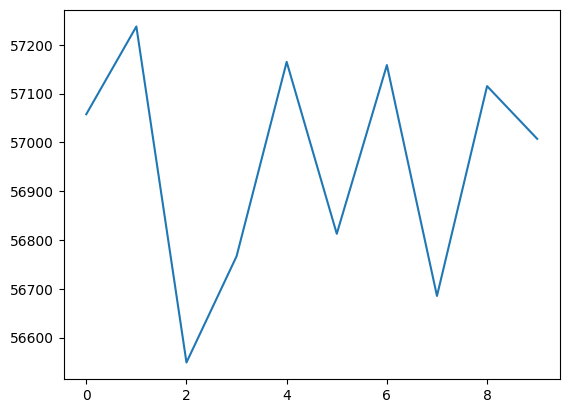

In [38]:
bpr_model.plot_loss()

#### Generating Prediction

Let say, we want to predict the preference to user 1 on item 1  

In [39]:
user_target = 1
item_target = 1
pred = bpr_model.predict(
    user_id= user_target,
    item_id= item_target
)

pred

3.2626766795933984

In [40]:
bpr_model.recommend_per_user(
    utility_data = song_playdata_mapped,
    user_column='userID',
    item_column='artistID',
    userid=1,
    N=5
)

[4958, 10947, 15680, 10066, 2112]

We see that our prediction is close enough, now we will evaluate in context of generated prediction using Precision Metrics, the way is simple

#### Evaluating Model

For, easier calculation we will use function to measure **NDCG@K**, we are going to use using NDCG@5 recommended item

In [41]:
def dcg(true_item, predicted_item, k):
    """Function to calculate DCG @ k"""
    # Create a store
    dcgs = []

    # iterate over the k
    for position in range(k):
        # Obtain relevance of item at position
        rel_pos = true_item[position] == predicted_item[position]

        # Calculate pos-th DCG
        dcg_pos = ((2**rel_pos)-1) / (np.log2(position+1 + 2))

        # Append to dcgs
        dcgs.append(dcg_pos)

    # Calculate the sum of DCG at every position
    score = np.sum(dcgs)

    return score

In [42]:
def ndcg(true_item, predicted_item, k) :
    """Function to calculate the normalized dcg @ k"""
    # Calculate DCG @ K
    dcg_result = dcg(true_item = true_item,
                     predicted_item = predicted_item,
                     k = k)

    # Calculate ideal DCG @ k
    idcg_result = dcg(true_item = true_item,
                      predicted_item = true_item,
                      k = k)

    # Normalize the DCG
    ndcg_result = dcg_result/idcg_result

    return ndcg_result

In [43]:
# create empty dictionary to
# loop all over userID
ndcg_all = np.zeros(mapped_data.userID.nunique() )
n_item_to_recommend = 5

for user in song_playdata_mapped.userID.unique() :
    #
    recommendation = bpr_model.recommend_per_user(utility_data = song_playdata_mapped,user_column='userID',item_column='artistID',
                                 userid=user,
                                 N=n_item_to_recommend,
                                 recommend_seen=True)

    # compare to data in mapped data
    user_true_consumed_item = mapped_data.loc[mapped_data['userID']==user,'artistID'].tolist()

    # we may have item recommended > number of user consumed item
    at_k = min(n_item_to_recommend,len(user_true_consumed_item))

    ndcg_at_k = ndcg(true_item = user_true_consumed_item[:at_k],
                          predicted_item = recommendation[:at_k],k=at_k)
    # append precision
    ndcg_all[user] = ndcg_at_k

avg_ndcg = np.mean(ndcg_all)
avg_ndcg

8.871898572453276e-05

## Train Recommender System Models
---

### Experiment
---

We want to train all model candidate with its hyperparameter so that we can compare which model + settings yield good result

<center>
<img src="../assets/ltr_experiment.png">
</center>

Since *Hyperparameter* Is not yielded through learning process, we have to find it / set it to yield optimal model performance

Some methods  Hyperparameter Tuning :    

- GridSearchCV

  Fitting model through all combinations of hyperparameter values and compare each fit → which combinations yield the best objective

- RandomizedSearchCV

  Fitting Model only through sampled hyperparameter candidates. Much more efficient than GridSearchCV

- Bayesian Optimization

  Using Bayesian Approach, which include sampling to find best parameter


**Cross Validation** Method

We are going to find the best hyperparameter by comparing sampled parameter combination on validation set

**Hyperparameter Method** : *Bayesian Optimization*


**Model Candidate**

1. Baseline Model : Alternating Least Squares
2. Bayesian Personalized Ranking

Using Model from Scratch may be benefit for us sometimes, such as getting know to the model inside out the model , however sometimes if we do it from scratch our code is not optimized both in data structure and languannge, since then for training purpose we will use package called Implicit

#### Load Data

In [44]:
full_data_path = '../data/user_artist_play.csv'

In [45]:
def preprocess_data(song_play_data) :
    """
    Function to preprocess data
    Parameters
    ----------
    song_play_data : pandas.DataFrame
        contain the song_play data

    Returns
    -------
    song_play_data : pandas DataFrame
        The sample of song_play data

    mapping_user : dict
        contain mappers :
        1. user to id
        2. id to user

    mapping_item : dict
        contain mappers :
        1. item to id
        2. id to item

    """
    # copy to avoid overwriting the original dataframe
    song_play_data = song_play_data.copy()
    
    # mapping step
    # mapping user to ordered id
    user_to_id = {user : idx for idx,user in enumerate(song_play_data['userID'].unique())}
    id_to_user = {idx : user for idx,user in enumerate(song_play_data['userID'].unique())}

    # mapping item to ordered id
    item_to_id = {item : idx for idx,item in enumerate(song_play_data['artistID'].unique())}
    id_to_item = {idx : item for idx,item in enumerate(song_play_data['artistID'].unique())}

    mapping_user = {'user_to_id' : user_to_id,'id_to_user' : id_to_user}
    mapping_item = {'item_to_id' : item_to_id,'id_to_item' : id_to_item}

    song_play_data['userID'] = song_play_data['userID'].map(user_to_id)
    song_play_data['artistID'] = song_play_data['artistID'].map(item_to_id)


    # create utility matrix
    row = song_play_data['userID'].values
    col = song_play_data['artistID'].values
    data = song_play_data['weight'].values


    utility_matrix = sp.coo_matrix((data, (row, col)))
     # return all product(including mapping)
    return utility_matrix, mapping_user,mapping_item

In [46]:
song_data_full = load_song_data(path=full_data_path)
song_utility_matrix,mapping_user,mapping_item = preprocess_data(song_play_data = song_data_full)

Original data shape : (92834, 3)


In [47]:
song_utility_matrix

<1892x17632 sparse matrix of type '<class 'numpy.int64'>'
	with 92834 stored elements in COOrdinate format>

Now, we are going to split the data into Three Subset :  
1. Training 60%
2. Validation 20%
3. Testing 20%

to perform this we can create function on our own

In [48]:
from implicit.evaluation import train_test_split
# split data into train and test
train_full,test = train_test_split(song_utility_matrix,train_percentage=0.8)

# set train_full to coo_again to perform splitting for validation data
train,val = train_test_split(song_utility_matrix,train_percentage=0.75)

/home/ubuntu/learning/recommendation_system/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
print('train shape',train.nnz)
print('val shape',val.nnz)
print('test shape',test.nnz)

train shape 69589
val shape 23245
test shape 18640


Since we will be using package called implicit, the package source code is fully optimized and considered fast, we can use full data.

We are going to run Hyperparameter Tuning for each model to know which model are the best , however our package, does not provide the hyperparameter tuning. Why don't we create one. We are going to create RandomizedSearchCV

So previously, we are only using sampled version of the data, because we are only demonstrating how the model works, and obviously our code is not fully optimized yet (Language and Data Structure) .

During model fitting process we will also use Hyperparameter Tuning to find best parameter combination to each model , for that we will use Bayesian Optimization Approach, using Optuna, we need to install it first

In [50]:
# install optuna
!pip install optuna

**Create Model Object**

##### **Baseline Model : Alternating Least Square**

What baseline model do could be based on popular item list

Hyperparameter :      
- factors : Number of Latent Factor
- regularization : regularization strength
- alpha : for confidence term $c= 1 + \alpha log(1+r_{ui})$


Some candidate value we will use
- factors : `[10,50,100,200,500]`
- regularization : `[0.0001, 0.001, 0.1 , 1.0 ]`
- alpha : `[0.001, 0.1 , 1.0,5.0 ]`

to create hyperparameter tuning, according to optuna documentation, we need to create objective, our goal is to find precision / recall

In [51]:
import optuna

# import model alternating least squares
from implicit import als
from implicit.evaluation import ndcg_at_k

def als_tuning(trial):
    factors = trial.suggest_int(name='factors',
                                             low=10,
                                             high=100,step=10)
    regularization = trial.suggest_float(name='regularization',
                                         low=0.0001,
                                         high=1.0,
                                         step= 0.001)

    alpha = trial.suggest_float(name='alpha',
                                      low=0.001,
                                      high=1.0,
                                      step= 0.001)

    # instanciate model
    model_als = als.AlternatingLeastSquares(factors=factors,
                                            regularization= regularization,
                                            alpha= alpha)

    # fit model
    model_als.fit(train)

    # test
    val_metrics = ndcg_at_k(model = model_als, train_user_items= train,
                                  test_user_items = val,K=5)
    return -val_metrics

# minimizing is equal to
study_als = optuna.create_study(direction="minimize")
study_als.optimize(als_tuning, n_trials=2)

[I 2024-11-29 08:53:09,082] A new study created in memory with name: no-name-4be847f7-037b-4816-bd92-026a5f64a639
/home/ubuntu/learning/recommendation_system/.venv/lib/python3.10/site-packages/optuna/distributions.py:689: UserWarning: The distribution is specified by [0.0001, 1.0] and step=0.001, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.9991].
  warnings.warn(
/home/ubuntu/learning/recommendation_system/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 1880/1880 [00:00<00:00, 4799.78it/s]
[I 2024-11-29 08:53:11,585] Trial 0 finished with value: -0.18432354336205506 and parameters: {'factors': 10

In [52]:
study_als.best_value

-0.20704585049012766

##### **Bayesian Personalized Ranking**

Hyperparameter :      
- factors : Number of Latent Factor
- regularization : regularization strength
- alpha : for confidence term $c= 1 + \alpha log(1+r_{ui})$


Some candidate value we will use
- factors : `[10,50,100,200,500]`
- regularization : `[0.0001, 0.001, 0.1 , 1.0 ]`
- alpha : `[0.001, 0.1 , 1.0,5.0 ]`

to create hyperparameter tuning, according to optuna documentation, we need to create objective, our goal is to find precision / recall

In [53]:
from implicit import bpr
def bpr_tuning(trial):
    factors = trial.suggest_int(name='factors',
                                             low=10,
                                             high=100,step=10)

    regularization = trial.suggest_float(name='regularization',
                                         low=0.0001,
                                         high=1.0,
                                         step= 0.001)

    learning_rate = trial.suggest_float(name='alpha',
                                      low=0.001,
                                      high=1.0,
                                      step= 0.001)

    # instanciate model
    bpr_model = bpr.BayesianPersonalizedRanking(factors=factors,
                                                regularization=regularization,
                                                learning_rate=learning_rate)



    # fit model
    bpr_model.fit(train)

    # test
    val_metrics = ndcg_at_k(model = bpr_model, train_user_items= train,
                                  test_user_items = val,K=5)
    return -val_metrics

# minimizing is equal to
study_bpr = optuna.create_study(direction="minimize")
study_bpr.optimize(bpr_tuning, n_trials=2)

[I 2024-11-29 08:53:13,962] A new study created in memory with name: no-name-5155590e-ed08-4dd2-a323-77242a885bc9
100%|██████████| 1880/1880 [00:00<00:00, 5603.63it/s]
[I 2024-11-29 08:53:15,665] Trial 0 finished with value: -0.001407760397061108 and parameters: {'factors': 100, 'regularization': 0.5871, 'alpha': 0.393}. Best is trial 0 with value: -0.001407760397061108.
100%|██████████| 1880/1880 [00:00<00:00, 5749.75it/s]
[I 2024-11-29 08:53:16,996] Trial 1 finished with value: -0.0 and parameters: {'factors': 40, 'regularization': 0.7591, 'alpha': 0.26}. Best is trial 0 with value: -0.001407760397061108.


In [54]:
#check best parameters and best score
study_bpr.best_params

{'factors': 100, 'regularization': 0.5871, 'alpha': 0.393}

In [55]:
-study_bpr.best_value

0.001407760397061108

#### **Summary**

After, we run experiment to our model, its better to recap the performance of our model

In [56]:
summary_df = pd.DataFrame({'Model': ['Baseline:Alternating Least Squares', 'Bayesian Personalized Ranking',],
                           'CV Performance - NDCG @5': [-1*study_als.best_value,-1*study_bpr.best_value],
                           'Model Condiguration':[f'{study_als.best_params}',f'{study_bpr.best_params}']})

summary_df

,Model,CV Performance - NDCG @5,Model Condiguration
0,Baseline:Alternating Least Squares,0.207046,"{'factors': 90, 'regularization': 0.0661, 'alp..."
1,Bayesian Personalized Ranking,0.001408,"{'factors': 100, 'regularization': 0.5871, 'al..."


We see that we have alternating Least Squares as our Best Models.

### Training Best Model
---

Now, we will train, our best models, **Alternating Least Squares** on full training data (Train + Val)

In [57]:
# Create object
best_params_als = study_als.best_params
model_best = als.AlternatingLeastSquares(**best_params_als)

# Retrain on whole train dataset
model_best.fit(train_full)

100%|██████████| 15/15 [00:01<00:00,  8.26it/s]


### Evaluate the Best Model
---

#### Evaluate Ranking Metrics

After finding the best model, we can sanity check the performance on the test dataset

Next, we predict the test set using our best model, using **NDCG @ 5**

In [58]:
test_score = ndcg_at_k(model = model_best, train_user_items= train_full,
                                  test_user_items = test,K=5)

100%|██████████| 1880/1880 [00:00<00:00, 5025.22it/s]


To summarize

In [59]:
summary_test_df = pd.DataFrame({'Model' : ['Alternating Least Squares'],
                                'NDCG@5-Tuning': [-study_als.best_value],
                                'NDCG@5': [test_score]})

summary_test_df

,Model,NDCG@5-Tuning,NDCG@5
0,Alternating Least Squares,0.207046,0.170216


Decision Process is to recommend items to user
from our trained model

# **3.Predictions / Generating Recommendation**
---

How do we generate recommendation ?


To generate recommendation :
- predict all movies or only unseen movies rating from given users
- followed by ordering the movies by its predicted rat

## Predict with Best Model : Alternating Least Squares

In [60]:
# Recommendation based on Best Models
# We will try to recommend on sample userid ,userId 1 & 99

# We can use model_best.recommend
help(model_best.recommend)

Help on method recommend in module implicit.cpu.matrix_factorization_base:

recommend(userid, user_items, N=10, filter_already_liked_items=True, filter_items=None, recalculate_user=False, items=None) method of implicit.cpu.als.AlternatingLeastSquares instance
    Recommends items for users.
    
    This method allows you to calculate the top N recommendations for a user or
    batch of users. Passing an array of userids instead of a single userid will
    tend to be more efficient, and allows multi-thread processing on the CPU.
    
    This method has options for filtering out items from the results. You can both
    filter out items that have already been liked by the user with the
    filter_already_liked_items parameter, as well as pass in filter_items to filter
    out other items for all users in the batch. By default all items in the training
    dataset are scored, but by setting the 'items' parameter you can restrict down to
    a subset.
    
    Example usage::
    
       

`model_best.recommend` has argument
- `userid` : userID
- `user_items` : Utility matrix for trianing model
- `N=10` : Number of item to recommend
- `filter_already_liked_items` : Whether to recommend seen items or not

### Let's Recommend artist to User 9

In [61]:
user_id = [9]
recommended_artist_id,_ = model_best.recommend(userid= user_id, user_items= train_full[user_id], N=10 )

In [62]:
recommended_artist_id

array([[248, 448, 282, 206, 651, 436, 238, 110, 259, 251]], dtype=int32)

In [63]:
# create dataframe first
recommended_artist_df = pd.DataFrame()
recommended_artist_df['artistID'] = recommended_artist_id[0]
recommended_artist_df['userID'] = 9
recommended_artist_df

,artistID,userID
0,248,9
1,448,9
2,282,9
3,206,9
4,651,9
5,436,9
6,238,9
7,110,9
8,259,9
9,251,9


We already have the recommended artist, however we don't have idea who it is, so we can load artist metadata to find out

First, we need to map back the `artistID` to original id

In [64]:
mapping_item.keys()

dict_keys(['item_to_id', 'id_to_item'])

In [65]:
recommended_artist_df['artistID'] = recommended_artist_df['artistID'].map(mapping_item['id_to_item'])
recommended_artist_df

,artistID,userID
0,299,9
1,498,9
2,333,9
3,257,9
4,701,9
5,486,9
6,289,9
7,161,9
8,310,9
9,302,9


Now, we can load the artist metadata

In [66]:
artist_metadata_path = '../data/artist_name.csv'

# read dataframe
artist_name = pd.read_csv(artist_metadata_path)
artist_name.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [67]:
# merge data
recommended_artist_df['artist_name'] = recommended_artist_df.merge(artist_name,right_on='id',left_on='artistID').loc[:,'name']

In [68]:
recommended_artist_df

,artistID,userID,artist_name
0,299,9,Jennifer Lopez
1,498,9,Paramore
2,333,9,Avril Lavigne
3,257,9,Mariah Carey
4,701,9,Shakira
5,486,9,30 Seconds to Mars
6,289,9,Britney Spears
7,161,9,Enrique Iglesias
8,310,9,Nelly Furtado
9,302,9,P!nk


Now, we can create a function to create recommendation for all users

In [69]:
def recommend_to_users(userid,user_items=train_full,N=10, artist_name = artist_name,
                       mapping_item = mapping_item) :
    # collect user id
    user_id = [userid]
    #
    recommended_artist_id,_ = model_best.recommend(userid= user_id, user_items= train_full[user_id], N=N )

    # create dataframe first
    recommended_artist_df = pd.DataFrame()
    recommended_artist_df['artistID'] = recommended_artist_id[0]
    recommended_artist_df['userID'] = userid


    recommended_artist_df['artistID'] = recommended_artist_df['artistID'].map(mapping_item['id_to_item'])
    # merge data
    recommended_artist_df['artist_name'] = recommended_artist_df.merge(artist_name,
                                                                       right_on='id',left_on='artistID').loc[:,'name']
    return recommended_artist_df

Lets try to recommend to user 100

In [70]:
# recommendation to user 100
recommend_to_users(userid=100)

,artistID,userID,artist_name
0,1835,100,The Cinematic Orchestra
1,744,100,Autechre
2,2677,100,Bola
3,4865,100,ISAN
4,2676,100,Tycho
5,2161,100,Wisp
6,2670,100,Chris Clark
7,1965,100,Four Tet
8,1156,100,Orbital
9,11206,100,The Black Dog


In [71]:
# recommendation to user 1000
recommend_to_users(userid=1000)

,artistID,userID,artist_name
0,2102,1000,倖田來未
1,302,1000,P!nk
2,548,1000,Ellie Goulding
3,378,1000,Evanescence
4,292,1000,Christina Aguilera
5,2543,1000,Lolene
6,1556,1000,Joss Stone
7,299,1000,Jennifer Lopez
8,291,1000,Kelly Clarkson
9,300,1000,Katy Perry
